In [1]:
using CSVFiles, DataFrames, Plots
using StatsBase
using Statistics
pyplot()

┌ Info: Recompiling stale cache file /home/ubuntu/.julia/compiled/v1.1/CSVFiles/kq3Uy.ji for CSVFiles [5d742f6a-9f54-50ce-8119-2520741973ca]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/ubuntu/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/ubuntu/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/ubuntu/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Plots.PyPlotBackend()

In [2]:
cd("/efs/tkwong/kaggle/LANL-Earthquake-Competition/")

In [3]:
@time df = load("train_100th.csv") |> DataFrame
;

 13.187509 seconds (47.51 M allocations: 2.343 GiB, 12.54% gc time)


In [4]:
function make_features(df, chunk_size)
    chunks = []
    statistics = (mean, minimum, maximum, median, skewness, kurtosis)
    column_symbols = Tuple(vcat(
            Symbol.(["signal_" * string(nameof(s)) for s in statistics]), 
            Symbol.(["quake_"  * string(nameof(s)) for s in statistics])))
    for i in 1:chunk_size:nrow(df)
        j = (i+chunk_size-1) > nrow(df) ? nrow(df) : (i+chunk_size-1)
        chunk = df[i:j, :]
        stats = vcat(
                [s(chunk[:acoustic_data]) for s in statistics], 
                [s(chunk[:time_to_failure]) for s in statistics])
        push!(chunks, NamedTuple{column_symbols}(stats))
    end
    chunks |> DataFrame
end

make_features (generic function with 1 method)

In [5]:
# Make 1500 samples (since we are using 100th sample from the train data set)
chunks = make_features(df, 1500)

,signal_mean,signal_minimum,signal_maximum,signal_median,signal_skewness,signal_kurtosis,quake_mean,quake_minimum,quake_maximum,quake_median,quake_skewness,quake_kurtosis
,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5.022,-92,44,5.0,-3.40678,71.1109,1.45019,1.4308,1.4691,1.45,-0.00358545,-1.20053
2,4.81933,-80,137,5.0,3.78102,121.352,1.41124,1.3915,1.4308,1.4117,0.00162887,-1.19801
3,4.81333,-69,91,5.0,0.394757,34.0318,1.37227,1.3532,1.3915,1.3723,-0.000398121,-1.19879
4,5.18133,-68,86,5.0,0.147251,43.8663,1.33331,1.3138,1.3532,1.3329,0.000207992,-1.19963
5,5.06467,-72,118,5.0,3.25275,56.5143,1.29434,1.2744,1.3138,1.2946,0.000951833,-1.1972
6,5.0,-46,55,5.0,0.917727,18.5957,1.25538,1.2361,1.2744,1.2553,-0.00116015,-1.20019
7,4.818,-26,41,5.0,0.685404,8.42093,1.21641,1.1968,1.2361,1.2159,0.00016642,-1.19575
8,4.51467,-81,65,5.0,-3.20815,65.1198,1.17745,1.1585,1.1968,1.1776,0.00147548,-1.19987
9,4.96067,-99,71,5.0,-0.341557,40.2795,1.13848,1.1191,1.1585,1.1382,-0.00091643,-1.19788


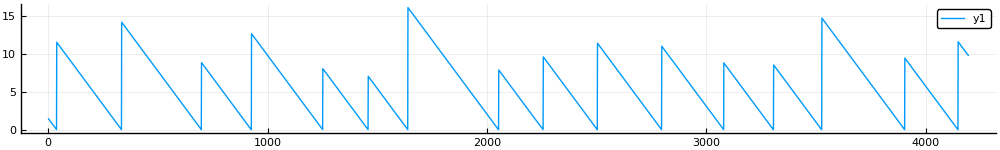

In [7]:
# The quake_minimum column should tell us the same story... when there's a quake.
plot(chunks[:quake_minimum], size = (1000, 150))

In [90]:
# Knowing that predictive power is diminished with these quake events,
# we would just exclude them.  
# Also, the last chunk is probably not useful since it's short.
# Let's discard that as well.
keep_flag = vcat(false, diff(chunks[:quake_minimum]) .< 5)
keep_flag[end] = false
chunks2 = chunks[keep_flag, :]
nrow(chunks2)

4177

In [109]:
# Data is probably skewed.  Let's take a look at mean/variance
[mean_and_var(chunks2[c]) for c in column_symbols]

6-element Array{Tuple{Float64,Float64},1}:
 (4.522281860984758, 0.13803155825353888)
 (-70.74120181948767, 20223.769932750685)
 (82.92051711754848, 22121.467818889614) 
 (4.527651424467321, 0.24761883632040824)
 (0.1922485453910141, 9.602548570050786) 
 (52.4805446646482, 3812.7797749094602)  

In [110]:
# Let's check the features correlation
cor(convert(Matrix, chunks2[1:6]))

6×6 Array{Float64,2}:
 1.0         0.10389     0.163082     0.579786    0.303719    0.0368064 
 0.10389     1.0        -0.816058     0.0104955   0.134843   -0.376644  
 0.163082   -0.816058    1.0          0.00039046  0.246549    0.423438  
 0.579786    0.0104955   0.00039046   1.0         0.0124744  -0.00608002
 0.303719    0.134843    0.246549     0.0124744   1.0         0.117913  
 0.0368064  -0.376644    0.423438    -0.00608002  0.117913    1.0       

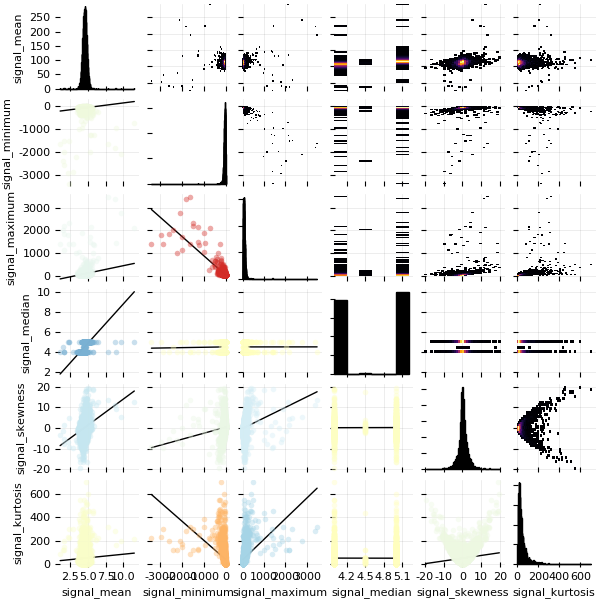

In [111]:
# Correlation analysis
@df chunks2 corrplot(
    [:signal_mean :signal_minimum :signal_maximum :signal_median :signal_skewness :signal_kurtosis],
    size = (600, 600), guidefontsize = 8)

In [113]:
# Let's standardize the feature columns
statistics = (mean, minimum, maximum, median, skewness, kurtosis)
feature_symbols = [Symbol("signal_" * string(nameof(s))) for s in statistics]
chunks3 = DataFrame()
for (s, col) in zip(statistics, feature_symbols)
    μ, σ = mean_and_var(chunks2[col])
    chunks3[col] = (chunks2[col] .- μ) / σ
end
chunks3[:quake_median] = copy(chunks2[:quake_median])
chunks3

,signal_mean,signal_minimum,signal_maximum,signal_median,signal_skewness,signal_kurtosis,quake_median
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.15205,-0.000457818,0.00244466,1.90756,0.373731,0.0180633,1.4117
2,2.10859,8.60968e-5,0.000365233,1.90756,0.021089,-0.00483865,1.3723
3,4.77464,0.000135544,0.000139208,1.90756,-0.00468605,-0.00225931,1.3329
4,3.92943,-6.22435e-5,0.00158577,1.90756,0.318717,0.00105797,1.2946
5,3.46093,0.00122337,-0.00126215,1.90756,0.0755506,-0.00888718,1.2553
6,2.1424,0.00221231,-0.00189502,1.90756,0.0513567,-0.0115558,1.2159
7,-0.05517,-0.000507264,-0.000810096,1.90756,-0.354114,0.00331496,1.1776
8,3.17598,-0.00139731,-0.000538866,1.90756,-0.05559,-0.00320004,1.1382
9,0.98324,0.000382777,0.000274823,1.90756,-0.112113,-0.00432128,1.0999


In [114]:
# Check and make sure that it's standardized!
[mean_and_var(chunks3[c]) for c in feature_symbols]

6-element Array{Tuple{Float64,Float64},1}:
 (6.804335511229114e-16, 7.244720067299261)    
 (5.980373007916213e-20, 4.944676503566155e-5) 
 (-2.691167853562296e-19, 4.520495693084595e-5)
 (-1.741909890874653e-15, 4.038464984570247)   
 (0.0, 0.1041390202512364)                     
 (0.0, 0.0002622758352267399)                  

In [132]:
# Linear regression
using MultivariateStats: llsq

# solve by linear least square
# https://multivariatestatsjl.readthedocs.io/en/stable/lreg.html
X = convert(Matrix, chunks3[1:end-1])
y = chunks3[:quake_median]
sol = llsq(X, y)
a, b = sol[1:end-1], sol[end]
yp = X * a .+ b

rmse = sqrt(mean(abs2.(y .- yp)))
println("rmse = $rmse")

mae = sum(abs.(y .- yp)) / length(y)
println("mae = $mae")

rmse = 3.592432792591126
mae = 2.96627629870123


In [133]:
# Let's try it without bias term
a = llsq(X, y; bias = false)
yp = X * a

rmse = sqrt(mean(abs2.(y .- yp)))
println("rmse = $rmse")

mae = sum(abs.(y .- yp)) / length(y)
println("mae = $mae")

rmse = 6.700275563180437
mae = 5.662100405149674


In [150]:
# use DecisionTreeRegressor
using DecisionTree, ScikitLearn

function test_decision_tree(regressor, X, y, X_test)
    ScikitLearn.fit!(regressor, X, y)
    y_test = ScikitLearn.predict(regressor, X_test)
    # Evaluate
    rmse = sqrt(mean(abs2.(y .- y_test)))
    println("rmse = $rmse")
    mae = sum(abs.(y .- y_test)) / length(y)
    println("mae = $mae")
end

test_decision_tree (generic function with 2 methods)

In [151]:
# Result looks better than llsq
test_decision_tree(DecisionTreeRegressor(), X, y, X)

rmse = 2.015554822869254
mae = 1.5215423584557188
